In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy
import math
from datetime import datetime
import matplotlib.animation as animation
from PIL import Image
import random
import pandas as pd

In [2]:
epsilon = math.ulp(1.0)

def softmax(x):
    return np.nan_to_num((np.exp(x)+epsilon))/np.nan_to_num((sum(np.exp(x))+epsilon))

def simulate_allstarts(eta,simlen,beta,a,h,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_log=np.zeros([simlen,P,N])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        for t in range(simlen):
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            r=softmax(beta*(x@xi))@projection-((1)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            x_log[t,start_node,:]=x
            m_log[t,start_node,:]=m
        x_last[:,start_node]=x
    autocorr = np.corrcoef(x_last.T) #correlation between attractors

    return (autocorr, m_log, x_log)

def simulate_allstarts_freq(eta,simlen,beta,a,h,freq,noise,H):
    m_log=np.zeros([simlen,P,P])
    x_last=np.zeros([N,P])
    projection=((a*xi)+(h*(xi@H))).T # auto+hetero
    for start_node in range(P):
        x=xi[:,start_node]+noise*(np.random.rand(N)-0.5)
        stim_node=start_node-freq
        for t in range(simlen):
            if (t>1) & (t%freq==0):
                x+=xi[:,stim_node%P]+0.0
                stim_node-=freq
            r=softmax(beta*(x@xi))@projection-((1/N)*(xi_mean.T))
            x+=eta*(r[0]-x)
            m=np.zeros(P)
            for i in range(P):
                m[i] = np.corrcoef(x,xi[:,i])[0,1]
            m_log[t,:,:]=m
        x_last[:,start_node]=x
    cor_activity=np.corrcoef(x_last.T) #correlation between attractors
    return (m_log, cor_activity)

def get_h(a):
    return 1-a

def get_a(h):
    return h-1

def corr_steps(x_log, xi, steps):
    corrs1 = corr_step(x_log, xi, steps[0])
    corrs2 = corr_step(x_log, xi, steps[1])
    corrs3 = corr_step(x_log, xi, steps[2])
    corrs4 = corr_step(x_log, xi, steps[3])
    return (corrs1, corrs2, corrs3, corrs4)

def corr_step(x_log, xi, step):
    corrs = np.zeros((P,P))
    for x_last in range(0,P):
        for pattern in range(0,P):
            corrs[x_last,pattern] = np.corrcoef(x_log[step,x_last,:],xi[:,pattern])[0][1]
    return corrs

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [3]:
N = 230_400
gorilla1_frames = np.zeros((N,50))
for i in range(1,10):
    gorilla1_frames[:,i-1] = load_image('gorilla1/ezgif-frame-00'+str(i)+'.png').flatten()
for i in range(11,51):
    gorilla1_frames[:,i-1] = load_image('gorilla1/ezgif-frame-0'+str(i)+'.png').flatten()
    
N = 230_400
gorilla2_frames = np.zeros((N,50))
for i in range(1,10):
    gorilla2_frames[:,i-1] = load_image('gorilla2/ezgif-frame-00'+str(i)+'.png').flatten()
for i in range(11,51):
    gorilla2_frames[:,i-1] = load_image('gorilla2/ezgif-frame-0'+str(i)+'.png').flatten()

In [4]:
N = 2000
P = np.shape(gorilla1_frames)[1]-1 # number of patterns

G_cycle = nx.cycle_graph(P, create_using=nx.DiGraph)
H = nx.adjacency_matrix(G_cycle) # adjacency matrix
pos_cycle = nx.circular_layout(G_cycle, scale=1)

#memories
frame_sample = random.sample(range(0, np.shape(gorilla1_frames)[0]), N)
xi=gorilla1_frames[frame_sample,:]/np.max(gorilla1_frames)
xi=np.delete(xi,9,1)
xi_mean=np.sum(xi, axis=1, keepdims=True)/P
xi_bias=xi-xi_mean

simlen = 100
beta = 0.6
eta = 0.2
noise = 1

D_diag = np.sum(H,axis=1)
D_diag_half_inv = 1/np.sqrt(np.sum(H,axis=1))
H=np.diag(D_diag_half_inv)@H@np.diag(D_diag_half_inv) # normalized adjacency matrix, $D^{-1/2} A D^{-1/2}$

a1=-1
h1=3
autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)

a2=-1.5
h2=3
autocorr2, m_log2, x_log2 = simulate_allstarts(eta,simlen,beta,a2,h2,noise,H)

a3=-2
h3=3
autocorr3, m_log3, x_log3 = simulate_allstarts(eta,simlen,beta,a3,h3,noise,H)

a4=-2
h4=3.5
autocorr4, m_log4, x_log4 = simulate_allstarts(eta,simlen,beta,a4,h4,noise,H)

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\3434025638.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


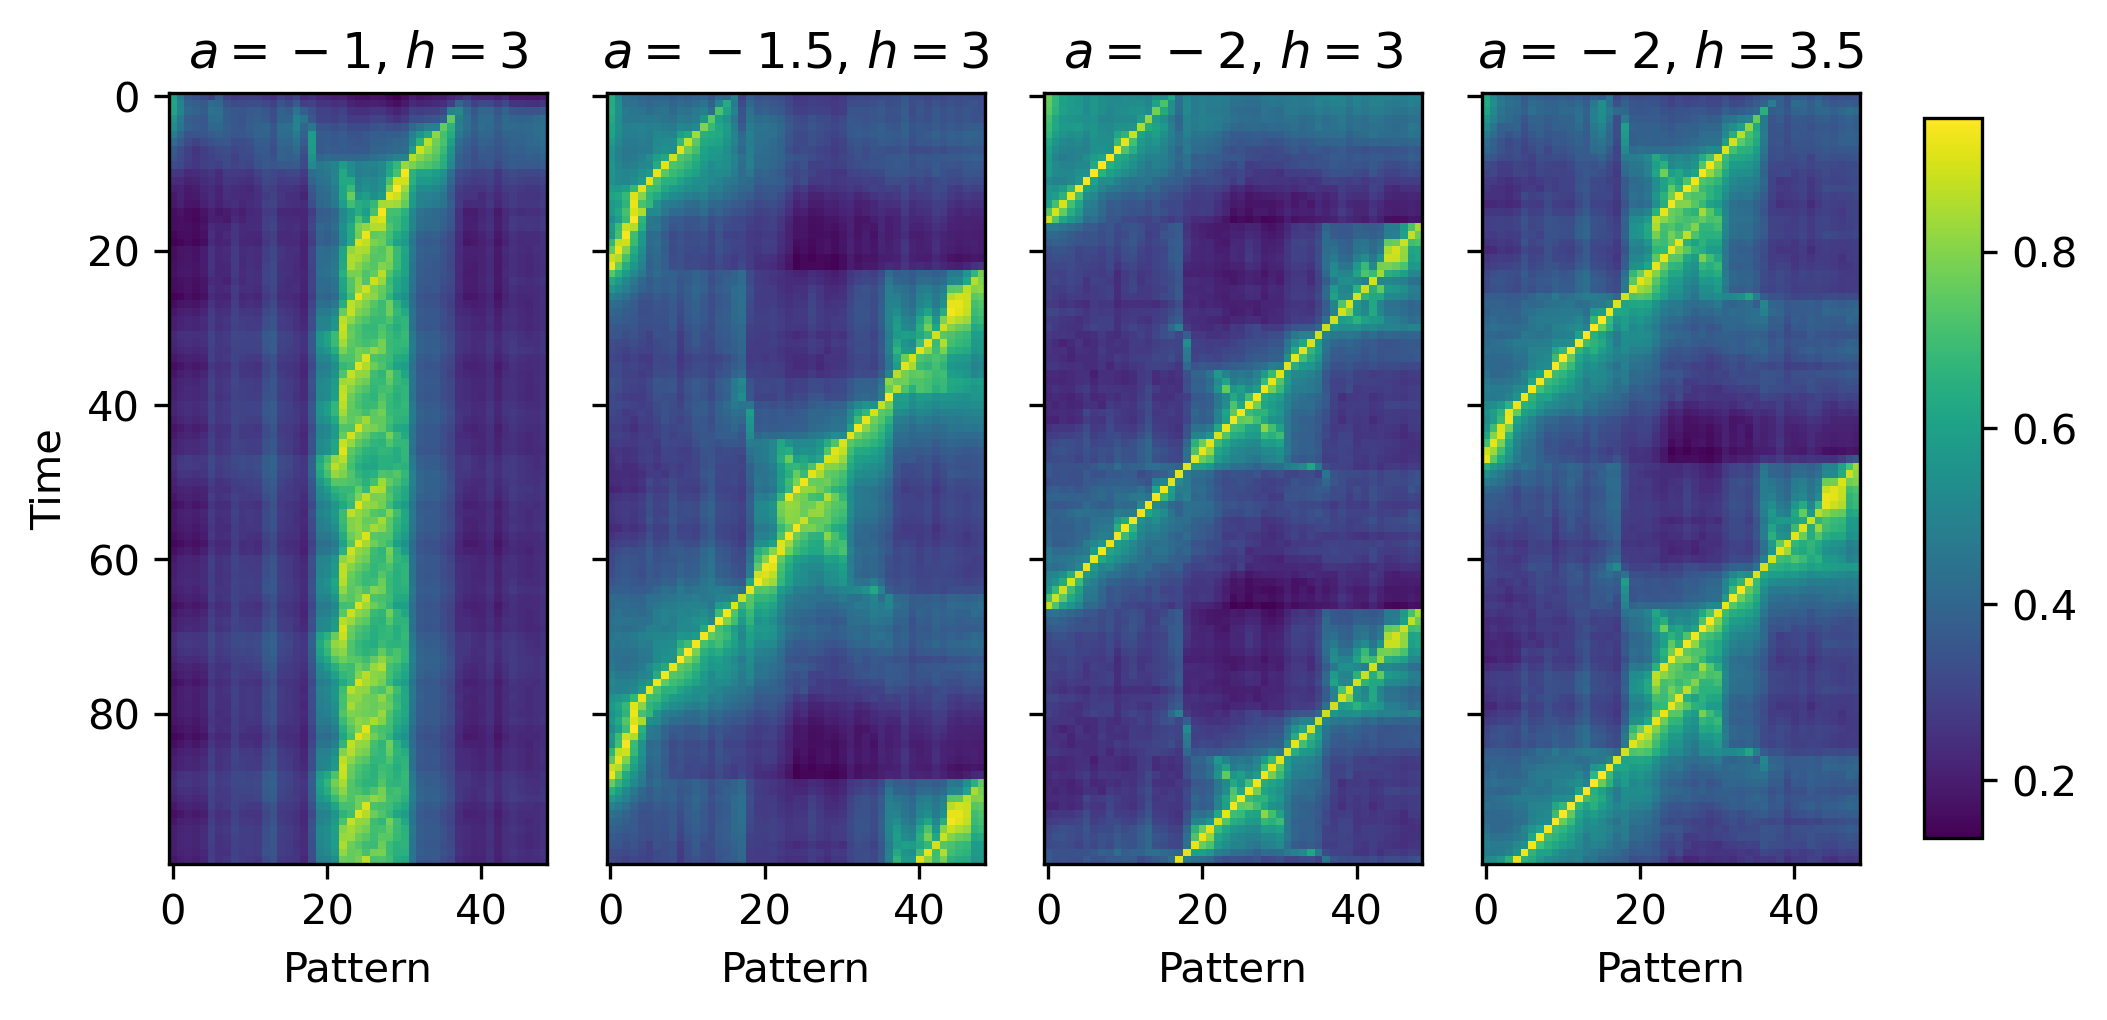

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(6.4,4), sharey=True, dpi=300)
im1 = axs[0].imshow(m_log1[:,0])
axs[0].set_ylabel("Time")
axs[0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
axs[0].set_xlabel("Pattern")

axs[1].imshow(m_log2[:,0])
axs[1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
axs[1].set_xlabel("Pattern")

axs[2].imshow(m_log3[:,0])
axs[2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
axs[2].set_xlabel("Pattern")

axs[3].imshow(m_log4[:,0])
axs[3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
axs[3].set_xlabel("Pattern")

now = np.datetime64(datetime.now())

cbar_ax = fig.add_axes([1.01, 0.2, 0.03, 0.6])
fig.colorbar(im1, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("mlog_cycle_gorilla1_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")

plt.show()

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\341576773.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


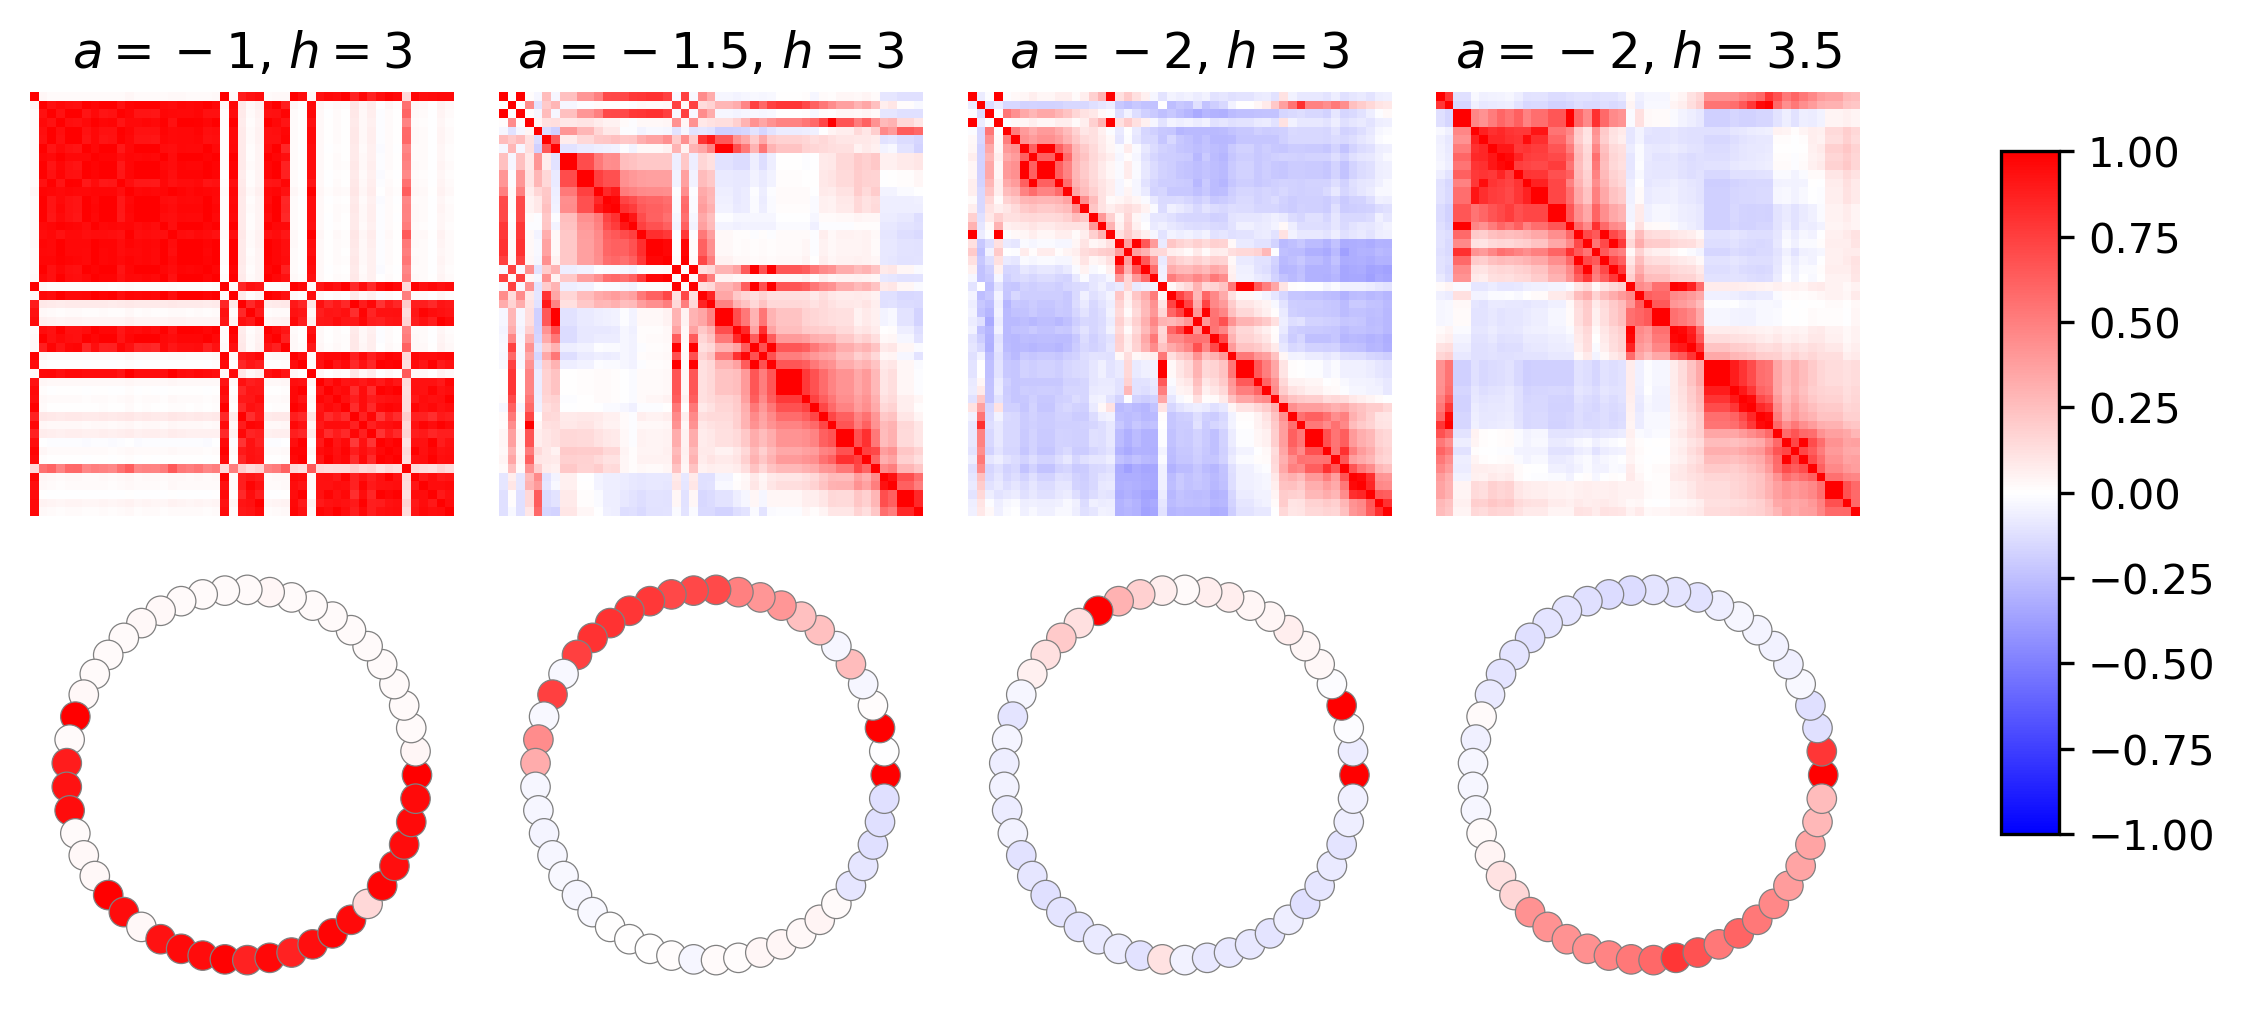

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(6.4,3.5), dpi=300)
stim_node = 0

axs[0, 0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
im1 = axs[0, 0].imshow(autocorr1, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 0].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 0], node_color=autocorr1[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
im2 = axs[0, 1].imshow(autocorr2, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 1].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 1], node_color=autocorr2[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
im3 = axs[0, 2].imshow(autocorr3, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 2].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 2], node_color=autocorr3[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
im4 = axs[0, 3].imshow(autocorr4, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 3].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 3], node_color=autocorr4[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

cbar_ax = fig.add_axes([1.05, 0.2, 0.03, 0.65])
fig.colorbar(im2, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("correlations_cycle-gorilla1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [7]:
N = 2000
P = np.shape(gorilla1_frames)[1]-1 # number of patterns

G_cycle = nx.cycle_graph(P, create_using=nx.DiGraph)
H = nx.adjacency_matrix(G_cycle) # adjacency matrix
pos_cycle = nx.circular_layout(G_cycle, scale=1)

#memories
frame_sample = random.sample(range(0, np.shape(gorilla1_frames)[0]), N)
xi=gorilla1_frames[frame_sample,:]/np.max(gorilla1_frames)
xi=np.delete(xi,9,1)
xi_mean=np.sum(xi, axis=1, keepdims=True)/P
xi_bias=xi-xi_mean

simlen = 100
beta = 1
eta = 0.1
noise = 1

D_diag = np.sum(H,axis=1)
D_diag_half_inv = 1/np.sqrt(np.sum(H,axis=1))
H=np.diag(D_diag_half_inv)@H@np.diag(D_diag_half_inv) # normalized adjacency matrix, $D^{-1/2} A D^{-1/2}$

a1=-1
h1=3
autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)

a2=-1.5
h2=3
autocorr2, m_log2, x_log2 = simulate_allstarts(eta,simlen,beta,a2,h2,noise,H)

a3=-2
h3=3
autocorr3, m_log3, x_log3 = simulate_allstarts(eta,simlen,beta,a3,h3,noise,H)

a4=-2
h4=3.5
autocorr4, m_log4, x_log4 = simulate_allstarts(eta,simlen,beta,a4,h4,noise,H)

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\3434025638.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


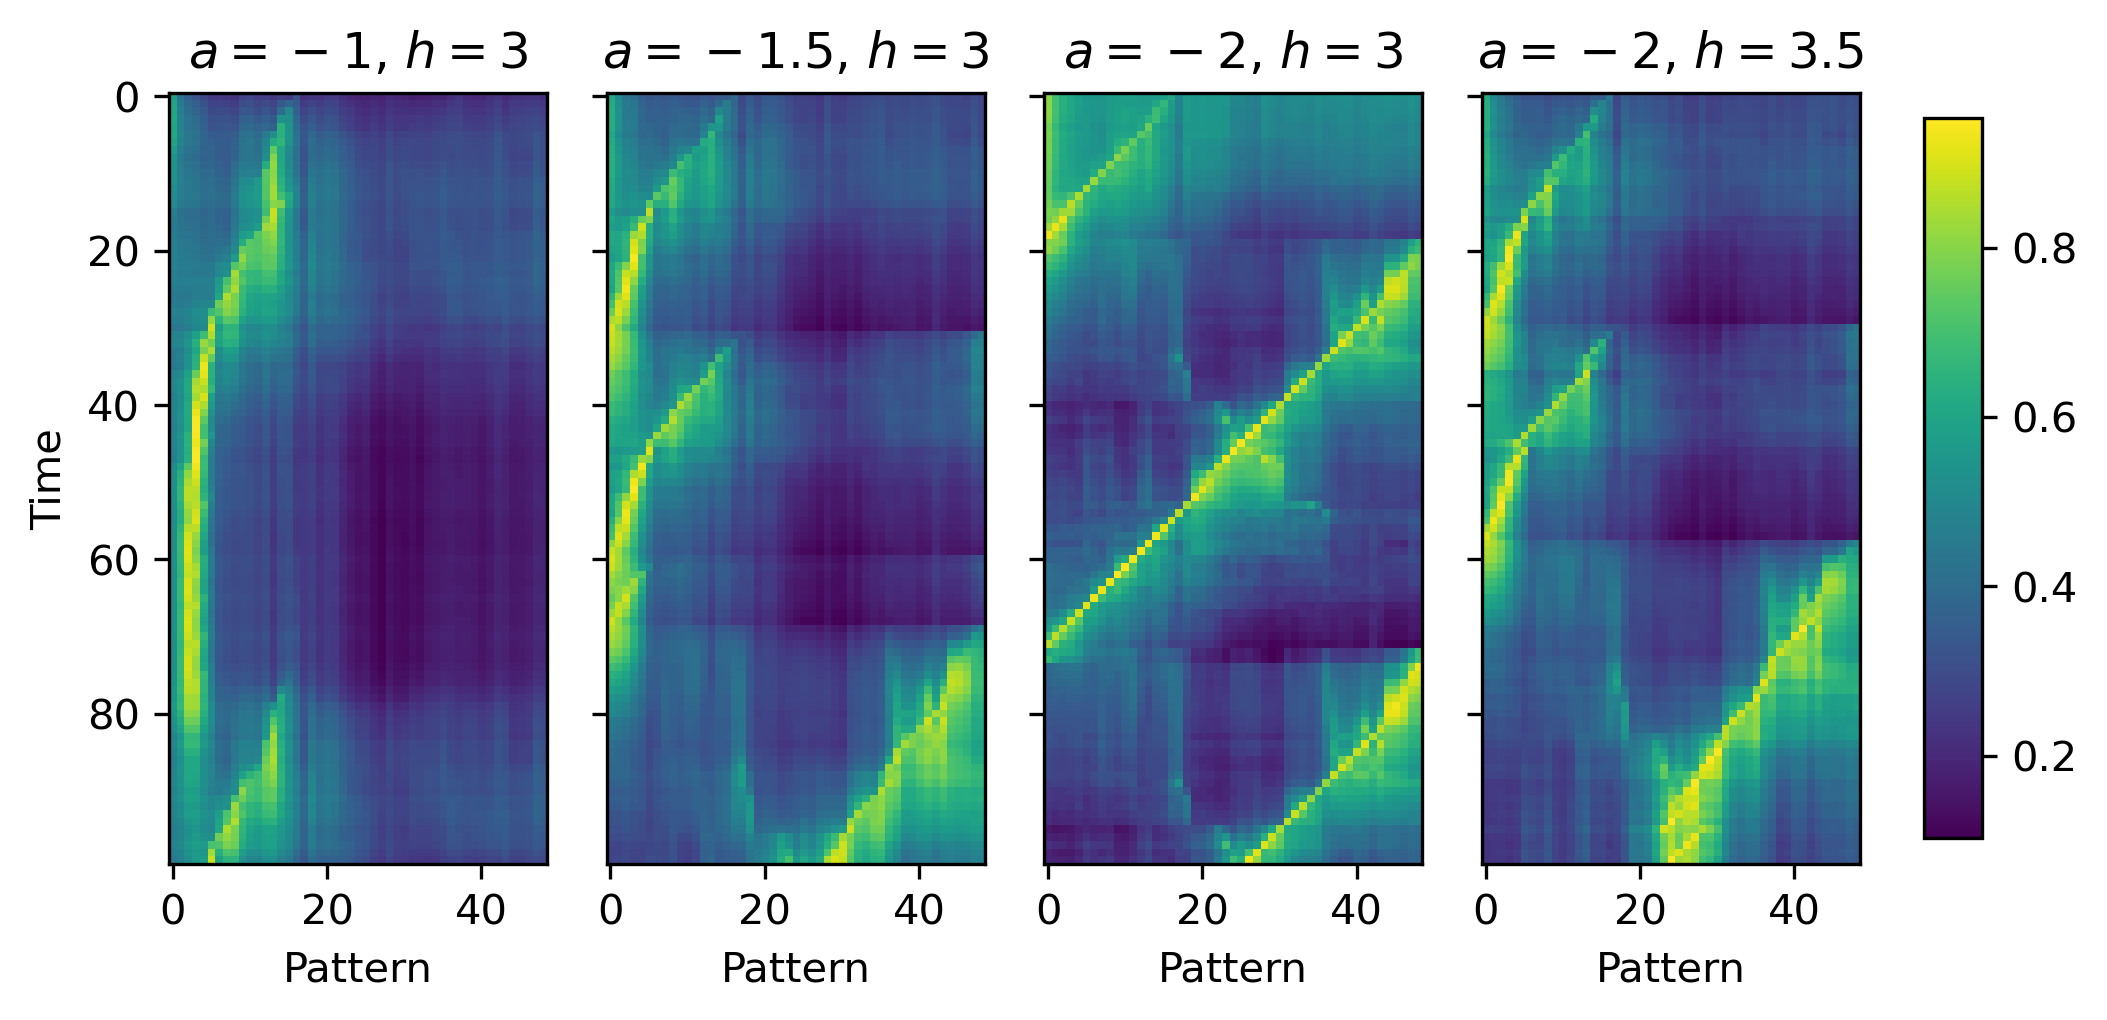

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(6.4,4), sharey=True, dpi=300)
im1 = axs[0].imshow(m_log1[:,0])
axs[0].set_ylabel("Time")
axs[0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
axs[0].set_xlabel("Pattern")

axs[1].imshow(m_log2[:,0])
axs[1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
axs[1].set_xlabel("Pattern")

axs[2].imshow(m_log3[:,0])
axs[2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
axs[2].set_xlabel("Pattern")

axs[3].imshow(m_log4[:,0])
axs[3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
axs[3].set_xlabel("Pattern")

now = np.datetime64(datetime.now())

cbar_ax = fig.add_axes([1.01, 0.2, 0.03, 0.6])
fig.colorbar(im1, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("mlog_cycle_gorilla1_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")

plt.show()

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\341576773.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


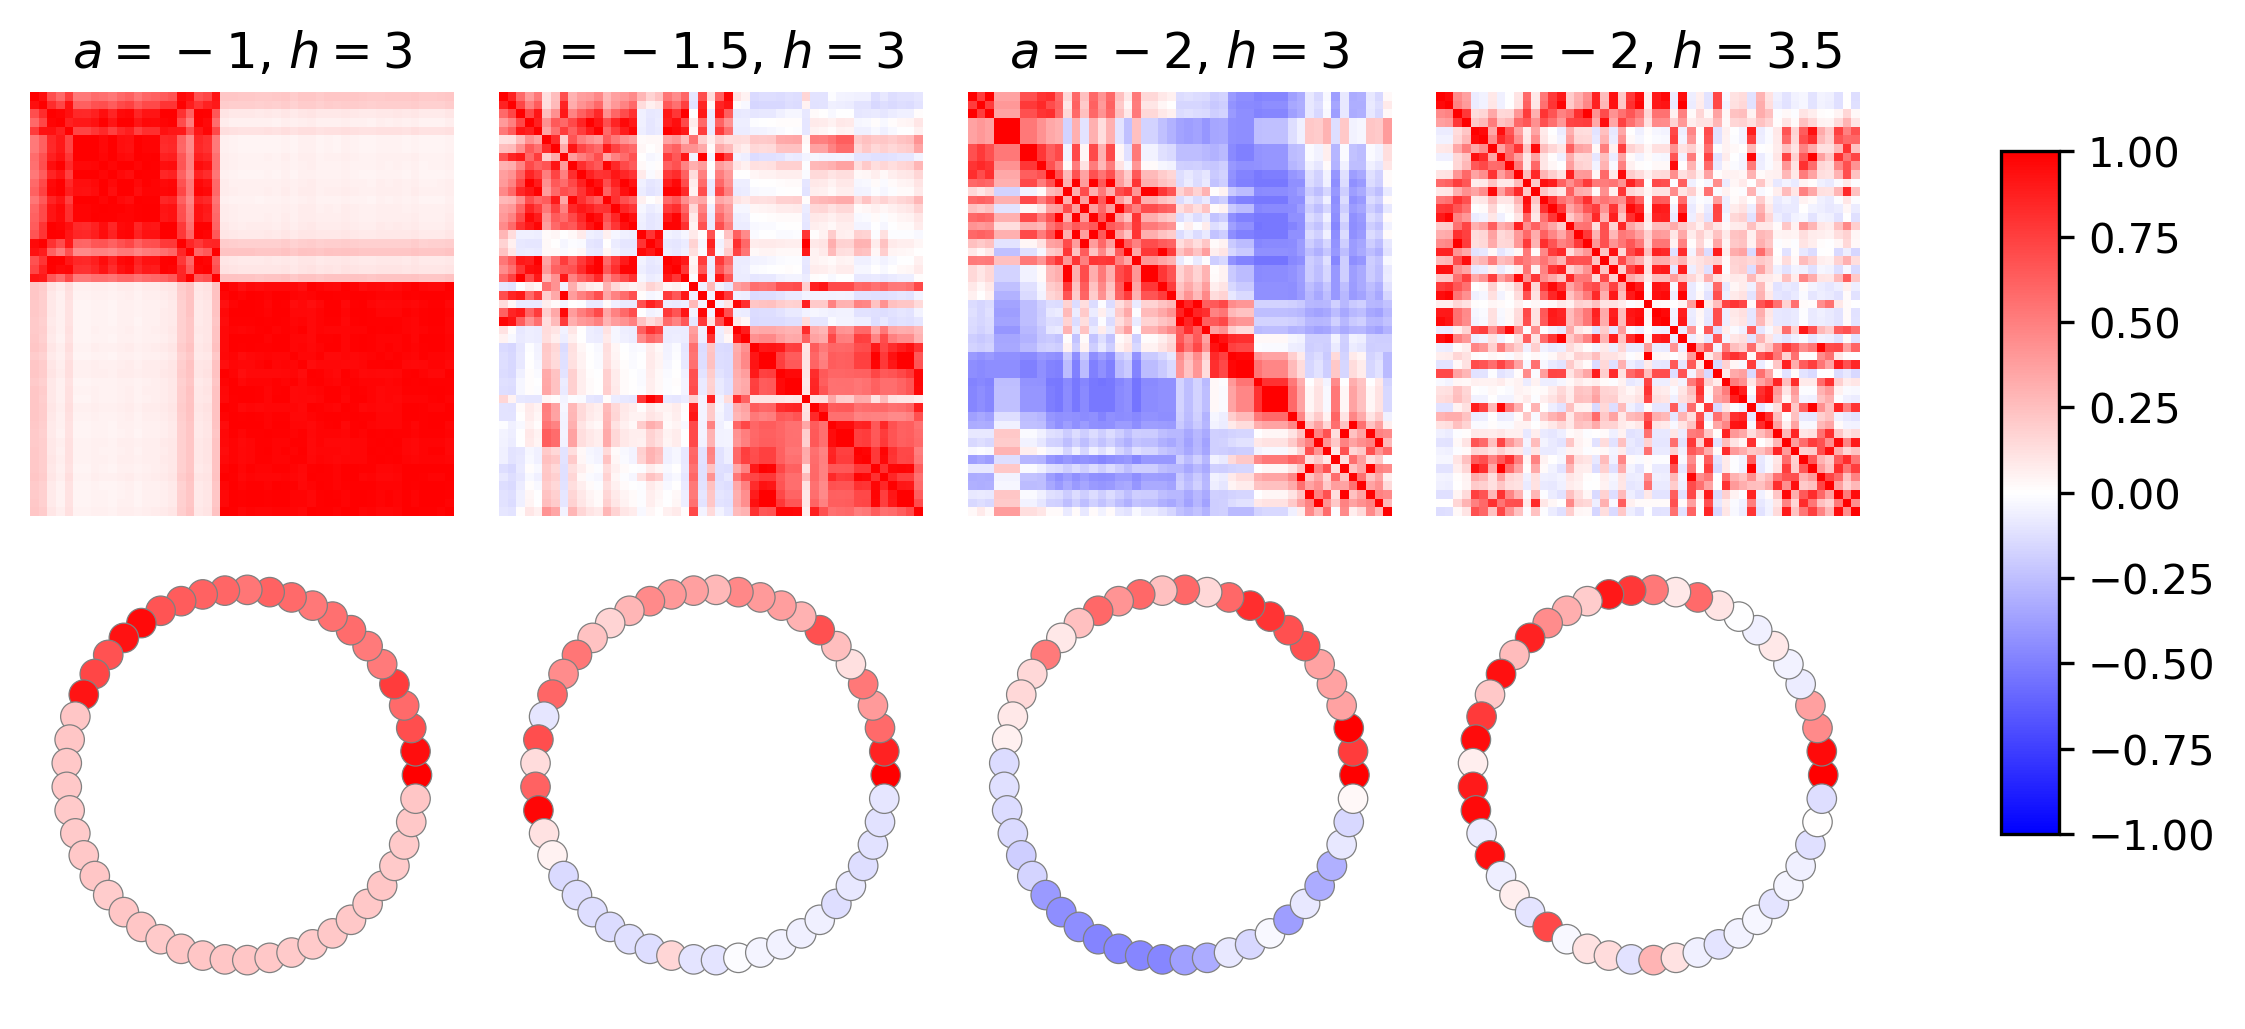

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(6.4,3.5), dpi=300)
stim_node = 0

axs[0, 0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
im1 = axs[0, 0].imshow(autocorr1, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 0].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 0], node_color=autocorr1[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
im2 = axs[0, 1].imshow(autocorr2, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 1].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 1], node_color=autocorr2[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
im3 = axs[0, 2].imshow(autocorr3, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 2].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 2], node_color=autocorr3[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
im4 = axs[0, 3].imshow(autocorr4, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 3].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 3], node_color=autocorr4[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

cbar_ax = fig.add_axes([1.05, 0.2, 0.03, 0.65])
fig.colorbar(im2, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("correlations_cycle-gorilla1.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [10]:
N = 2000
P = np.shape(gorilla2_frames)[1]-1 # number of patterns

G_cycle = nx.cycle_graph(P, create_using=nx.DiGraph)
H = nx.adjacency_matrix(G_cycle) # adjacency matrix
pos_cycle = nx.circular_layout(G_cycle, scale=1)

#memories
frame_sample = random.sample(range(0, np.shape(gorilla2_frames)[0]), N)
xi=gorilla2_frames[frame_sample,:]/np.max(gorilla2_frames)
xi=np.delete(xi,9,1)
xi_mean=np.sum(xi, axis=1, keepdims=True)/P
xi_bias=xi-xi_mean

simlen = 100
beta = 0.6
eta = 0.2
noise = 1

D_diag = np.sum(H,axis=1)
D_diag_half_inv = 1/np.sqrt(np.sum(H,axis=1))
H=np.diag(D_diag_half_inv)@H@np.diag(D_diag_half_inv) # normalized adjacency matrix, $D^{-1/2} A D^{-1/2}$

a1=-1
h1=3
autocorr1, m_log1, x_log1 = simulate_allstarts(eta,simlen,beta,a1,h1,noise,H)

a2=-1.5
h2=3
autocorr2, m_log2, x_log2 = simulate_allstarts(eta,simlen,beta,a2,h2,noise,H)

a3=-2
h3=3
autocorr3, m_log3, x_log3 = simulate_allstarts(eta,simlen,beta,a3,h3,noise,H)

a4=-2
h4=3.5
autocorr4, m_log4, x_log4 = simulate_allstarts(eta,simlen,beta,a4,h4,noise,H)

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\4226606030.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


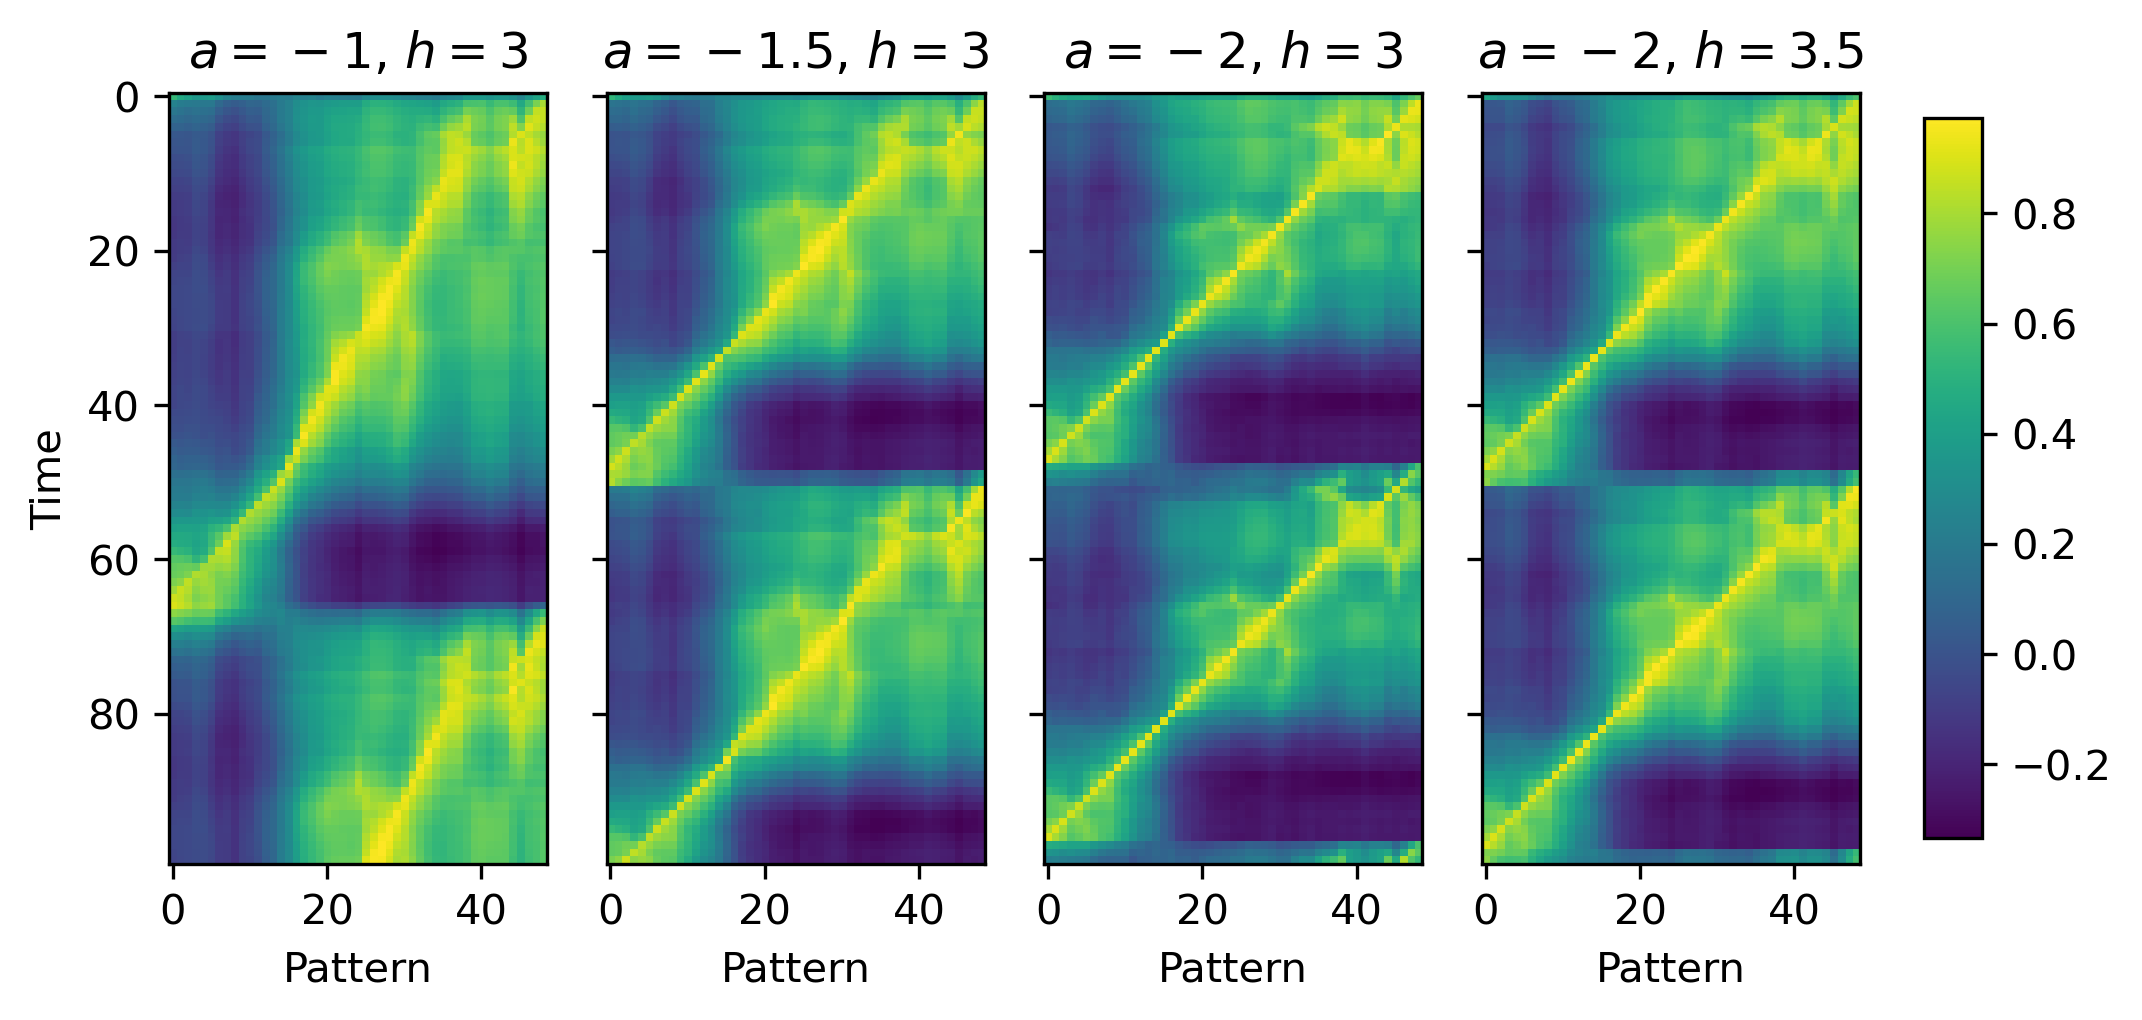

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(6.4,4), sharey=True, dpi=300)
im1 = axs[0].imshow(m_log1[:,0])
axs[0].set_ylabel("Time")
axs[0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
axs[0].set_xlabel("Pattern")

axs[1].imshow(m_log2[:,0])
axs[1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
axs[1].set_xlabel("Pattern")

axs[2].imshow(m_log3[:,0])
axs[2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
axs[2].set_xlabel("Pattern")

axs[3].imshow(m_log4[:,0])
axs[3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
axs[3].set_xlabel("Pattern")

now = np.datetime64(datetime.now())

cbar_ax = fig.add_axes([1.01, 0.2, 0.03, 0.6])
fig.colorbar(im1, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("mlog_cycle_gorilla2_"+str((now.astype('uint64') / 1e6).astype('uint32'))+".pdf", format="pdf", bbox_inches="tight")

plt.show()

C:\Users\Thomas Burns\AppData\Local\Temp\ipykernel_20124\2515539482.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


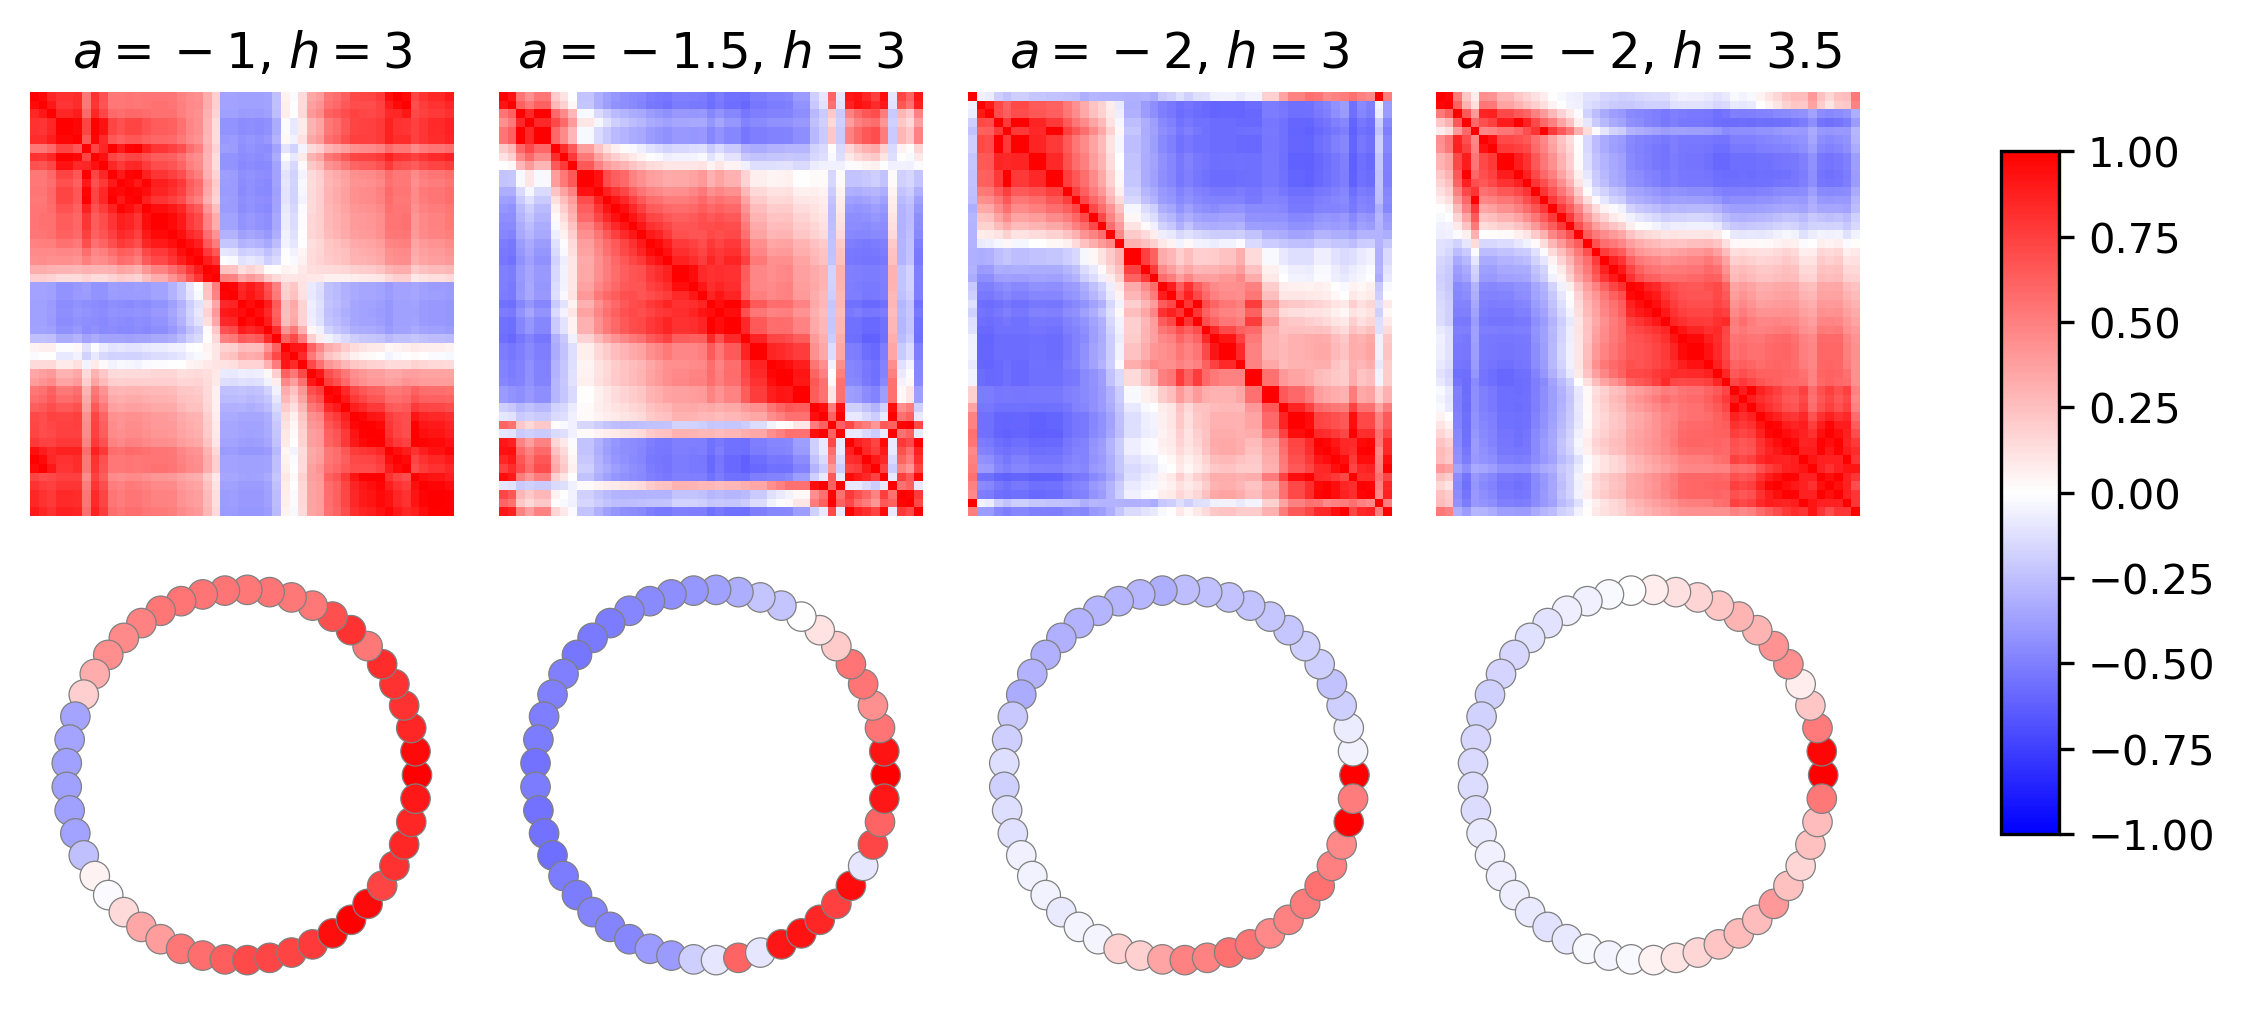

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(6.4,3.5), dpi=300)
stim_node = 0

axs[0, 0].title.set_text('$a='+str(a1)+'$, $h='+str(h1)+'$')
im1 = axs[0, 0].imshow(autocorr1, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 0].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 0], node_color=autocorr1[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 1].title.set_text('$a='+str(a2)+'$, $h='+str(h2)+'$')
im2 = axs[0, 1].imshow(autocorr2, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 1].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 1], node_color=autocorr2[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 2].title.set_text('$a='+str(a3)+'$, $h='+str(h3)+'$')
im3 = axs[0, 2].imshow(autocorr3, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 2].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 2], node_color=autocorr3[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

axs[0, 3].title.set_text('$a='+str(a4)+'$, $h='+str(h4)+'$')
im4 = axs[0, 3].imshow(autocorr4, cmap='bwr', interpolation='nearest', vmin=-1, vmax=1)
axs[0, 3].axis('off')
nx.draw(G_cycle, pos=pos_cycle, ax=axs[1, 3], node_color=autocorr4[stim_node,:], node_size=50,
                    cmap='bwr', vmin=-1, vmax=1, linewidths=0.3, edgecolors='gray', edge_color='gray')

cbar_ax = fig.add_axes([1.05, 0.2, 0.03, 0.65])
fig.colorbar(im2, cax=cbar_ax)
plt.tight_layout()
# plt.savefig("correlations_cycle-gorilla2.pdf", format="pdf", bbox_inches="tight")
plt.show()